In [2]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time
%matplotlib inline

# Extend PATH Variable
import sys
sys.path.append("src/")

# NanoNets Simulation Tool
import nanonets
import nanonets_utils

# Plot Colors
blue_color  = '#348ABD'
red_color   = '#A60628'

In [4]:
voltages = np.random.uniform(-0.1,0.1, size=(300,9))

topology_parameter = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[3,0,0],[6,0,0],[0,3,0],[0,6,0],[3,6,0],[6,3,0],[6,6,0]]
}

In [5]:
def autocorrelation(x : np.array, y : np.array, lags : int):

    return [np.corrcoef(x, y)[0,1] if l==0 else np.corrcoef(x[:-l], y[l:])[0,1] for l in range(lags)]

In [6]:
def run_kmc(voltages, topology_parameter, sim_dic):

    np_network_cubic = nanonets.simulation(network_topology='cubic', topology_parameter=topology_parameter)
    np_network_cubic.run_const_voltages(voltages=voltages, target_electrode=1, save_th=0.1, output_potential=False, sim_dic=sim_dic, verbose=True)

    df              = pd.DataFrame(np.hstack((voltages,np_network_cubic.return_output_values())))
    I_target_values = np_network_cubic.I_target_values
    t_vals          = np_network_cubic.time_values
    
    return df, pd.DataFrame(I_target_values).T, pd.DataFrame(t_vals).T

In [7]:
def return_parameters(jumps_per_batch, max_jumps):

    sim_dic1 ={
        'error_th'        : 0.05,
        'max_jumps'       : max_jumps,
        'eq_steps'        : 1000,
        'jumps_per_batch' : jumps_per_batch,
        'kmc_counting'    : False
    }

    sim_dic2 ={
        'error_th'        : 0.05,
        'max_jumps'       : max_jumps,
        'eq_steps'        : 1000,
        'jumps_per_batch' : jumps_per_batch,
        'kmc_counting'    : True
    }

    return sim_dic1, sim_dic2

In [8]:
sim_dic1, sim_dic2  = return_parameters(1, 200*1)
df1, I1, t1_vals = run_kmc(voltages, topology_parameter, sim_dic1)

In [7]:
batch_sizes = [1,2,4,8,16,32,64,128,256,512,1024,2048]
dic_gamma   = {} 
dic_gamma_I = {}
dic_count   = {}
dic_count_I = {}
dic_gamma_t = {}
dic_count_t = {}
time_gamma  = []
time_count  = []

for j_per_batch in batch_sizes:

    sim_dic1, sim_dic2  = return_parameters(j_per_batch, 200*j_per_batch)

    # Gamma
    t1 = time.process_time()
    df1, I1, tg = run_kmc(voltages, topology_parameter, sim_dic1)
    t2 = time.process_time()

    dic_gamma[j_per_batch]      = df1
    dic_gamma_I[j_per_batch]    = I1
    dic_gamma_t[j_per_batch]    = tg
    time_gamma.append(t2-t1)

    # Count
    df2, I2, tc = run_kmc(voltages, topology_parameter, sim_dic2)
    t3 = time.process_time()

    dic_count[j_per_batch]      = df2
    dic_count_I[j_per_batch]    = I2
    dic_count_t[j_per_batch]    = tc
    time_count.append(t3-t2)

In [16]:
dic_gamma[1]

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.029179,-0.072655,0.032791,0.093865,-0.078276,0.080408,-0.009788,-0.028363,-0.057111,1000.0,2.0,1578.548498,0.000003
1,-0.045081,0.056960,0.045126,0.090408,0.027164,0.054845,0.085493,-0.000718,-0.087906,1000.0,200.0,-99.866206,14.190250
2,-0.094106,-0.095976,-0.010975,0.055823,-0.017497,0.027288,0.035581,0.070871,-0.084685,1000.0,108.0,761.843642,37.883586
3,0.067399,-0.083771,-0.035623,0.088983,0.045777,-0.069768,-0.044780,0.019032,0.067769,1000.0,33.0,888.280449,43.606291
4,-0.029295,-0.062722,-0.029692,-0.057532,-0.012063,0.034480,-0.029185,0.060250,0.086757,1000.0,2.0,811.517222,0.004587
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.049093,-0.083912,-0.043862,-0.075829,0.052651,-0.071429,0.062816,-0.097782,-0.001512,1000.0,2.0,607.339128,0.000791
296,-0.067084,0.053186,0.086435,0.013606,0.036464,0.014097,0.013732,0.049560,-0.050248,1000.0,69.0,-512.397010,25.486197
297,-0.022175,0.047041,-0.016530,0.053176,-0.052372,-0.052536,0.049106,0.088512,0.054242,1000.0,2.0,-10.340893,0.000159
298,0.023470,0.058305,-0.046449,-0.059274,-0.030624,-0.098337,0.015074,-0.089604,-0.024116,1000.0,2.0,-1300.993730,0.000272


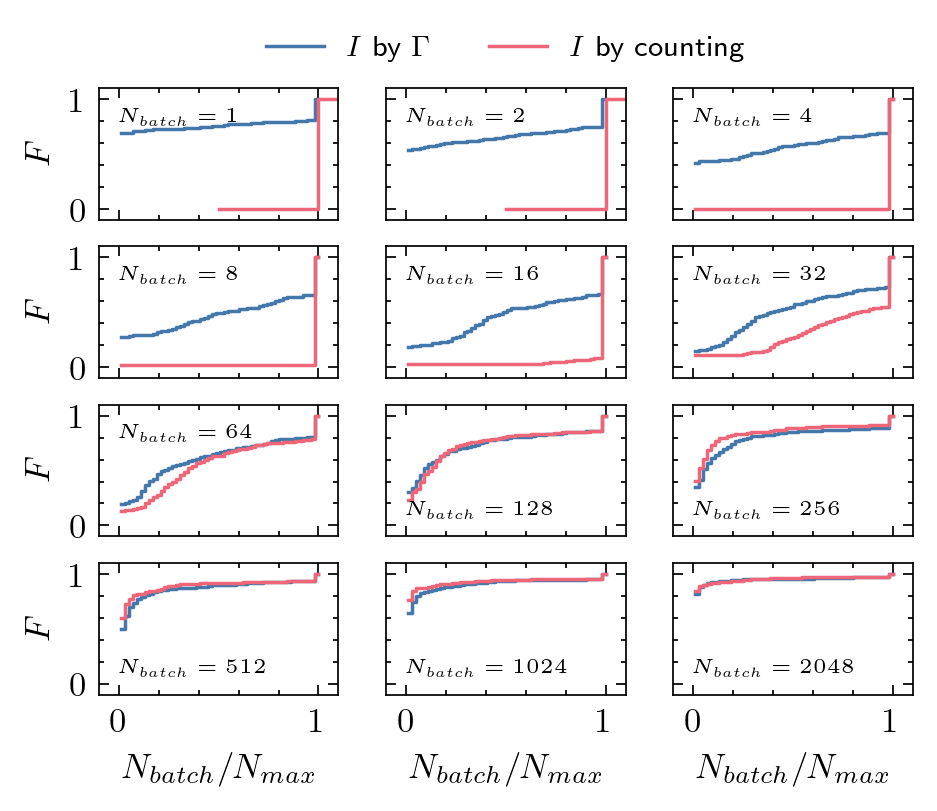

In [26]:
ncol = 3
nrow = 4

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=250)
    fig.set_figheight(fig.get_figheight()*1.2)
    fig.set_figwidth(fig.get_figwidth()*1.2)

    for i, j_per_batch in enumerate(dic_gamma.keys()):

        ax  = fig.add_subplot(nrow,ncol,i+1)
        ax  = sns.histplot(dic_gamma[j_per_batch][10]/(200*j_per_batch), label="$I$ by $\Gamma$", cumulative=True, bins=50, element='step', fill=False, stat='probability')
        ax  = sns.histplot(dic_count[j_per_batch][10]/(200*j_per_batch), label="$I$ by counting", cumulative=True, bins=50, element='step', fill=False, stat='probability')
        ax.set_xlim(-0.1,1.1)
        ax.set_ylim(-0.1,1.1)
    
        if i % ncol != 0:
            ax.set_ylabel('')
            ax.set_yticklabels('')
        else:
            ax.set_ylabel('$F$')
        
        if i >= (nrow-1)*ncol:
            ax.set_xlabel('$N_{batch}/N_{max}$')
        else:
            ax.set_xlabel('')
            ax.set_xticklabels('')

        if (i == 0):
            ax.legend(loc='center',bbox_to_anchor=(1.7,1.3), fontsize='small', ncol=2)

        if i < 7:
            ax.text(x=0,y=0.8,s='$N_{batch}' + f' = {j_per_batch}$', fontsize='xx-small')
        else:
            ax.text(x=0,y=0.1,s='$N_{batch}' + f' = {j_per_batch}$', fontsize='xx-small')

    fig.savefig("docs/current_estimation/cum_dist_jumps.png")

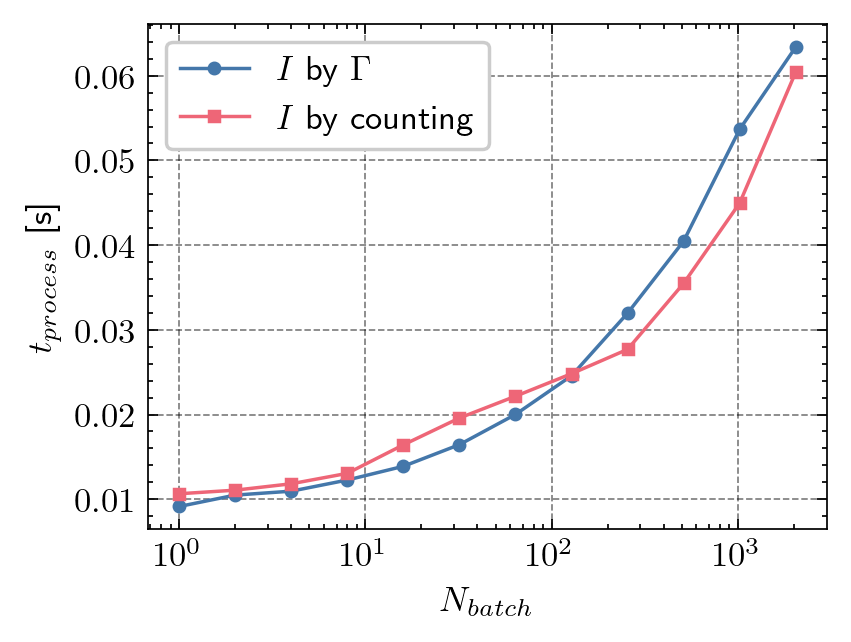

In [31]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=250)
    ax  = fig.add_subplot()
    ax.plot(batch_sizes, np.array(time_gamma)/300, 'o-', label="$I$ by $\Gamma$", ms=3)
    ax.plot(batch_sizes, np.array(time_count)/300, 's-', label="$I$ by counting", ms=3)
    ax.set_ylabel('$t_{process}$ [s]')
    ax.set_xlabel('$N_{batch}$')
    ax.legend()
    # ax.set_yscale('log') 
    ax.set_xscale('log')
    fig.savefig("docs/current_estimation/simulation_duration.png")

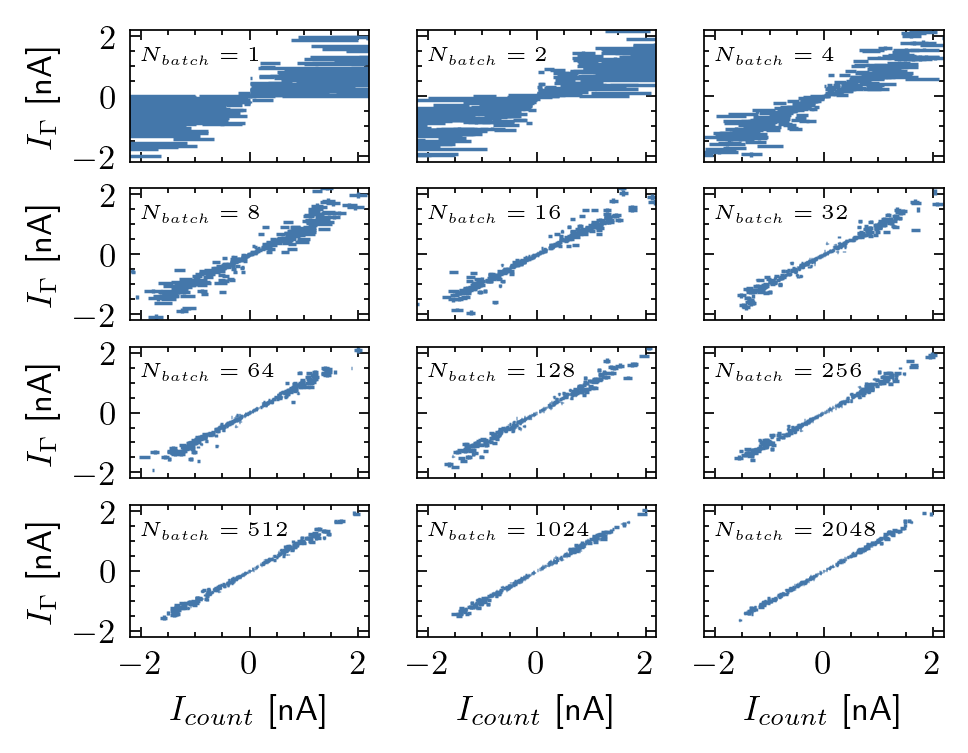

In [30]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=250)
    fig.set_figheight(fig.get_figheight()*1.2)
    fig.set_figwidth(fig.get_figwidth()*1.2)

    for i, j_per_batch in enumerate(dic_gamma.keys()):

        ax  = fig.add_subplot(nrow,ncol,i+1)
        ax.errorbar(x=dic_count[j_per_batch][11]/1000, y=dic_gamma[j_per_batch][11]/1000, xerr=dic_count[j_per_batch][12]/1000, yerr=dic_gamma[j_per_batch][12]/1000, ls='')

        ax.set_xlim(-2.2,2.2)
        ax.set_ylim(-2.2,2.2)
    
        if i % ncol != 0:
            ax.set_ylabel('')
            ax.set_yticklabels('')
        else:
            ax.set_ylabel('$I_{\Gamma}$ [nA]')
        
        if i >= (nrow-1)*ncol:
            ax.set_xlabel('$I_{count}$ [nA]')
        else:
            ax.set_xlabel('')
            ax.set_xticklabels('')

        ax.text(x=-2,y=1.2,s='$N_{batch}' + f' = {j_per_batch}$', fontsize='xx-small')
    fig.savefig("docs/current_estimation/I_vs_I.png")

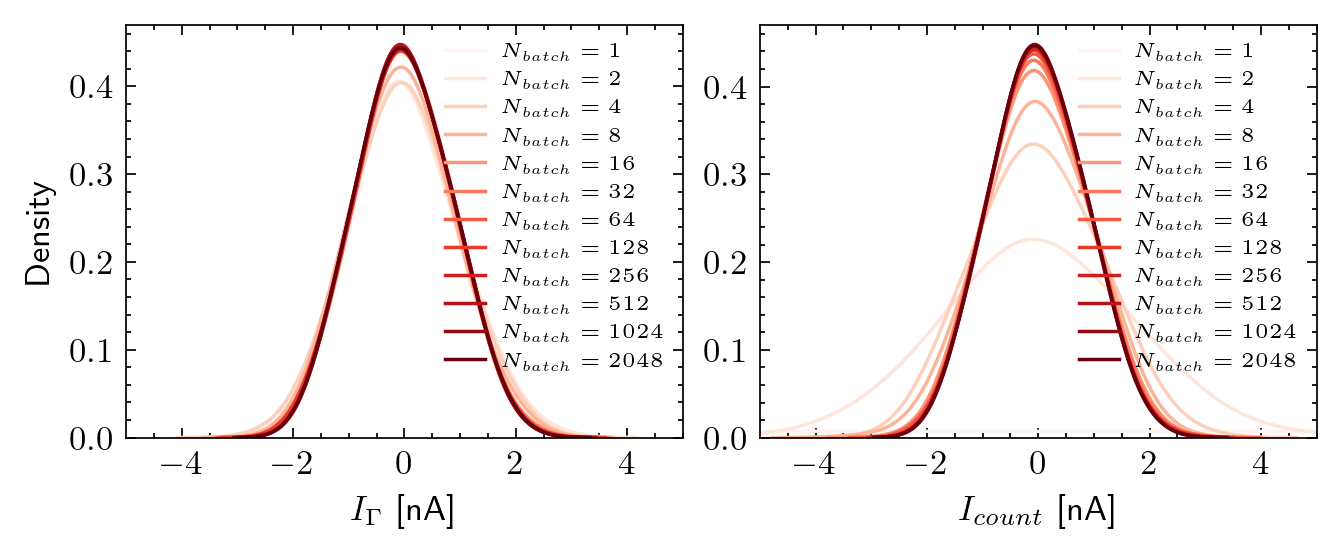

In [33]:
cmap = plt.get_cmap('Reds')

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=250, layout='constrained')
    fig.set_figheight(fig.get_figheight()*0.8)
    fig.set_figwidth(fig.get_figwidth()*1.5)

    ax  = fig.add_subplot(1,2,1)

    for i, j_per_batch in enumerate(dic_gamma.keys()):

        # ax.errorbar(x=np.arange(300), y=dic_gamma[j_per_batch][11]/1000, yerr=dic_gamma[j_per_batch][12]/1000, ls='-')
        ax = sns.kdeplot(dic_gamma[j_per_batch][11]/1000, bw_adjust=2, color=cmap(i/(len(dic_gamma.keys())-1)), label='$N_{batch}'+f' = {j_per_batch}$')
        ax.set_xlabel('$I_{\Gamma}$ [nA]')
    
    ax.legend(fontsize='xx-small')
    ax.set_xlim(-5,5)

    ax  = fig.add_subplot(1,2,2)

    for i, j_per_batch in enumerate(dic_gamma.keys()):

        # ax.errorbar(x=np.arange(300), y=dic_gamma[j_per_batch][11]/1000, yerr=dic_gamma[j_per_batch][12]/1000, ls='-')
        ax = sns.kdeplot(dic_count[j_per_batch][11]/1000, bw_adjust=2, color=cmap(i/(len(dic_gamma.keys())-1)), label='$N_{batch}'+f' = {j_per_batch}$')
        ax.set_xlabel('$I_{count}$ [nA]')

    ax.set_xlim(-5,5)
    ax.legend(fontsize='xx-small')
    ax.set_ylabel('')
    fig.savefig("docs/current_estimation/I_dists.png")

In [82]:
import warnings
warnings.filterwarnings("error")

In [111]:
key = 1

x_vals          = dic_gamma_t[key].copy()
x_vals.loc[-1]  = 0
x_vals.index    = x_vals.index + 1
x_vals          = x_vals.sort_index()
x_vals          = x_vals.iloc[:40].cumsum()

time_vals   = np.linspace(0,0.23,100)
auto_vals   = []

for col in range(300):
    try:
        y_vals      = autocorrelation(dic_gamma_I[key].iloc[:50,col].values,dic_gamma_I[key].iloc[:50,col].values,40)
        func        = interp1d(x_vals[col].values*1e9, y_vals)
        auto_val    = func(time_vals)
        auto_vals.append(auto_val)
    except RuntimeWarning:
        pass
auto_vals = np.mean(auto_vals,axis=0)

In [112]:
auto_dic = {}
for key in dic_gamma_I.keys():
    auto_val = []

    for col in range(300):
        try:
            y_vals  = autocorrelation(dic_gamma_I[key].iloc[:50,col].values, dic_gamma_I[key].iloc[:50,col].values,40)
            auto_val.append(y_vals)
        except RuntimeWarning:
            pass

    auto_dic[key] = np.mean(auto_val,axis=0)

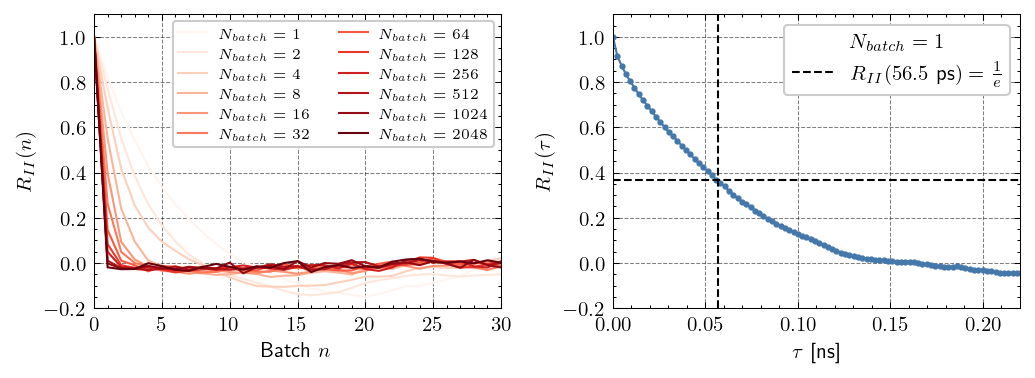

In [138]:
cmap = plt.get_cmap('Reds')

with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=150, layout='tight')
    fig.set_figwidth(fig.get_figwidth()*2)

    ax  = fig.add_subplot(1,2,1)
    for i, (key, df) in enumerate(auto_dic.items()):
        ax.plot(df, label='$N_{batch}' + f'= {key}$', color=cmap(i/(len(dic_gamma.keys())-1)))
    ax.set_ylabel("$R_{II}(n)$")
    ax.set_xlabel("Batch $n$")
    ax.set_xlim(0,30)
    ax.set_ylim(-0.2,1.1)
    ax.legend(ncol=2, fontsize='x-small')

    ax  = fig.add_subplot(1,2,2)
    ax.plot(time_vals, auto_vals, marker='o', ms=2)
    ax.hlines(y=1/np.exp(1), xmin=0, xmax=0.6, colors='black', zorder=10, linestyles='dashed')
    ax.vlines(x=0.0565, ymin=-0.2, ymax=1.1, colors='black',label="$R_{II}(56.5$ ps$) = \\frac{1}{e}$", zorder=10, linestyles='dashed')
    ax.set_xlabel("$\\tau$ [ns]")
    ax.set_ylabel("$R_{II}(\\tau)$")
    ax.set_xlim(0,0.22)
    ax.set_ylim(-0.2,1.1)
    ax.legend(title='$N_{batch} = 1$')

    # fig.savefig("docs/current_estimation/auto_corr.png")

# Memristive Resistance

In [1]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time
%matplotlib inline

# Extend PATH Variable
import sys
sys.path.append("src/")

# NanoNets Simulation Tool
import nanonets
import nanonets_utils

import warnings
warnings.filterwarnings("error")

# Plot Colors
blue_color  = '#348ABD'
red_color   = '#A60628'

In [2]:
voltages = np.random.uniform(-0.1,0.1, size=(300,9))

topology_parameter = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[3,0,0],[6,0,0],[0,3,0],[0,6,0],[3,6,0],[6,3,0],[6,6,0]]
}

In [41]:
def run_memristor_kmc(voltages, topology_parameter, sim_dic, res_info):

    np_network_cubic = nanonets.simulation(network_topology='cubic', topology_parameter=topology_parameter, res_info=res_info)
    np_network_cubic.run_const_voltages(voltages=voltages, target_electrode=1, save_th=0.1, output_potential=False, sim_dic=sim_dic, verbose=True)

    df              = pd.DataFrame(np.hstack((voltages,np_network_cubic.return_output_values())))
    I_target_values = np_network_cubic.I_target_values
    t_vals          = np_network_cubic.time_values
    
    return df, pd.DataFrame(I_target_values).T, pd.DataFrame(t_vals).T

def return_mem_params(tau_0, jumps_per_batch=1):
    max_jumps       = 500*jumps_per_batch

    res_info = {
        "mean_R"    : 25.0,
        "std_R"     : 0.0,
        "dynamic"   : True,
        'slope'     : 0.8,
        'shift'     : 7.5,
        'tau_0'     : tau_0,
        'R_max'     : 25,
        'R_min'     : 10
    }
    res_sim_dic = {
        'error_th'        : 0.05,
        'max_jumps'       : max_jumps,
        'eq_steps'        : 10000,
        'jumps_per_batch' : jumps_per_batch,
        'kmc_counting'    : False
    }

    return res_info, res_sim_dic

def autocorrelation(x : np.array, y : np.array, lags : int):

    return [np.corrcoef(x, y)[0,1] if l==0 else np.corrcoef(x[:-l], y[l:])[0,1] for l in range(lags)]

In [42]:
dic_mem     = {}
dic_I_mem   = {}
dic_t_mem   = {}
tau_0_vals  = np.logspace(-11,-7,12)

for tau_0 in tau_0_vals:

    res_info, res_sim_dic   = return_mem_params(tau_0)
    df_mem, I_mem, t_mem    = run_memristor_kmc(voltages, topology_parameter, res_sim_dic, res_info)

    dic_mem[tau_0]      = df_mem
    dic_I_mem[tau_0]    = I_mem
    dic_t_mem[tau_0]    = t_mem

In [48]:
auto_dic    = {}
time_vals   = np.linspace(0,0.07,100)

for key in dic_I_mem.keys():
    x_vals          = dic_t_mem[key].copy()
    x_vals.loc[-1]  = 0
    x_vals.index    = x_vals.index + 1
    x_vals          = x_vals.sort_index()
    x_vals          = x_vals.iloc[:40].cumsum()
    auto_vals       = []
    print(key)
    for col in range(300):
        try:
            y_vals      = autocorrelation(dic_I_mem[key].iloc[:50,col].values,dic_I_mem[key].iloc[:50,col].values,40)
            func        = interp1d(x_vals[col].values*1e9, y_vals)
            auto_val    = func(time_vals)
            auto_vals.append(auto_val)
        except RuntimeWarning:
            pass
    auto_dic[key] = np.mean(auto_vals,axis=0)

1e-11
2.310129700083158e-11
5.336699231206302e-11
1.2328467394420634e-10
2.848035868435805e-10
6.579332246575682e-10
1.519911082952933e-09
3.5111917342151273e-09
8.11130830789689e-09
1.8738174228603867e-08
4.328761281083061e-08
1e-07


In [49]:
t_c = []
for key, arr in auto_dic.items():
    t_c.append(time_vals[np.where(arr > 1/np.exp(1))[0][-1]])

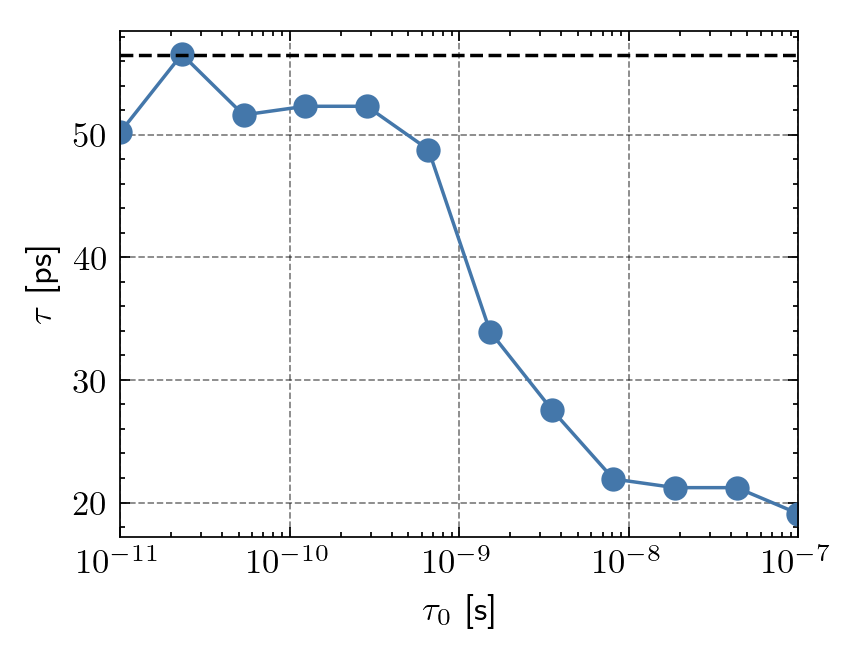

In [55]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=250)
    ax  = fig.add_subplot()
    ax.plot(tau_0_vals, np.array(t_c)*1000, 'o-')
    ax.hlines(56.5,np.min(tau_0_vals),np.max(tau_0_vals), colors='black', zorder=10, linestyles='dashed')
    ax.set_xscale('log')
    ax.set_ylabel('$\\tau$ [ps]')
    ax.set_xlabel('$\\tau_0$ [s]')
    ax.set_xlim(np.min(tau_0_vals),np.max(tau_0_vals))

In [129]:
def sig_figs(x: float, precision: int):
    x = float(x)
    precision = int(precision)
    return round(x, -int(np.floor(np.log10(abs(x)))) + (precision - 1))

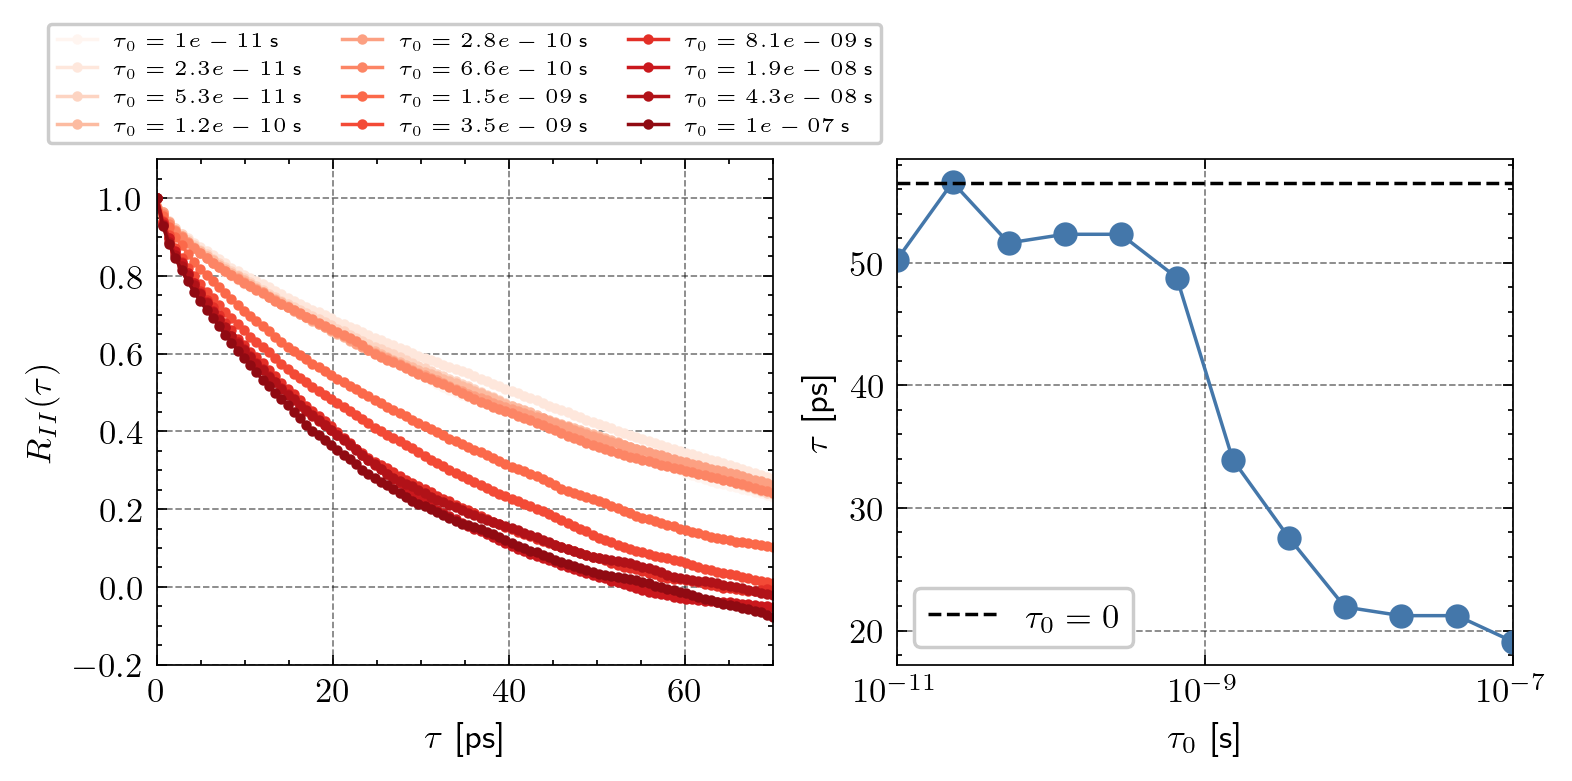

In [153]:
cmap = plt.get_cmap('Reds')
import matplotlib as mpl

with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=250)
    fig.set_figwidth(fig.get_figwidth()*2)
    ax  = fig.add_subplot(1,2,1)

    for i, (key, df) in enumerate(auto_dic.items()):
        ax.plot(time_vals*1000, df, marker='o', ms=2, label=f'$\\tau_0 = {sig_figs(key,2)}$ s', c=cmap(i/len(auto_dic.keys())))

    # ax.hlines(y=1/np.exp(1), xmin=0, xmax=0.6, colors='black', zorder=10, linestyles='dashed')
    # ax.vlines(x=0.0565, ymin=-0.2, ymax=1.1, colors='black',label="$R_{II}(56.5$ ps$) = \\frac{1}{e}$", zorder=10, linestyles='dashed')
    ax.set_xlabel("$\\tau$ [ps]")
    ax.set_ylabel("$R_{II}(\\tau)$")
    ax.set_xlim(0,70)
    ax.set_ylim(-0.2,1.1)
    ax.legend(fontsize='xx-small', ncol=3, bbox_to_anchor=(0.5,1.15), loc='center')

    ax  = fig.add_subplot(1,2,2)
    ax.plot(tau_0_vals, np.array(t_c)*1000, 'o-')
    ax.hlines(56.5,np.min(tau_0_vals),np.max(tau_0_vals), colors='black', zorder=10, linestyles='dashed', label='$\\tau_0 = 0$')
    ax.set_xscale('log')
    ax.set_ylabel('$\\tau$ [ps]')
    ax.set_xlabel('$\\tau_0$ [s]')
    ax.set_xlim(np.min(tau_0_vals),np.max(tau_0_vals))
    ax.legend(loc='lower left')

    fig.savefig("time_scale_memory.png")

In [6]:
def update_bimodal_resistance(I_tilde, slope : float, shift : float, R_max=30, R_min=20):
        ele_charge  = 0.160217662
        R1          = R_max*ele_charge*ele_charge*1e-12
        R2          = R_min*ele_charge*ele_charge*1e-12
        resistances = (R1 - R2)*(-np.tanh(slope*(I_tilde - shift)) + 1)/2 + R2
        return resistances

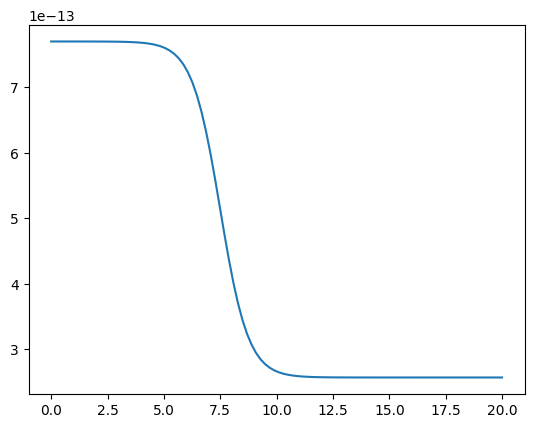

In [8]:
plt.plot(np.linspace(0,20,100), update_bimodal_resistance(np.linspace(0,20,100), 0.8, 7.5, 30, 10))

In [12]:
t_vals = t1_vals[0].values
t_vals

array([6.42260535e-11, 1.72705255e-11, 1.20787371e-12, 7.78338000e-14,
       1.82287189e-11, 1.00725306e-11, 2.03742733e-11, 2.96149363e-13,
       1.54615609e-13, 4.25122930e-11, 8.04743638e-11, 2.32201696e-11,
       5.17846288e-11, 1.58153703e-11, 5.68583901e-11, 1.51603772e-11,
       5.34313859e-11, 9.83130060e-12, 6.19322453e-12, 7.06768384e-12,
       9.08471361e-12, 1.10303463e-11, 3.38372442e-12, 1.02112060e-11,
       3.40772661e-11, 8.57021388e-12, 2.38077809e-11, 6.47073514e-12,
       7.50419880e-12, 3.31694321e-11, 6.33315970e-12, 5.45405679e-13,
       5.71036307e-12, 1.11541712e-11, 1.32665312e-11, 6.88284880e-12,
       2.70130768e-11, 1.07754538e-11, 1.37893806e-11, 2.24672734e-11,
       6.28495674e-12, 5.89008228e-11, 6.47556304e-11, 9.07226550e-13,
       6.68098190e-12, 2.43481593e-11, 1.72742176e-11, 2.88419171e-11,
       2.23975106e-12, 2.56631775e-11, 1.56763686e-12, 6.02528034e-12,
       2.11533601e-12, 8.32314468e-12, 1.84489773e-12, 1.88640032e-11,
      

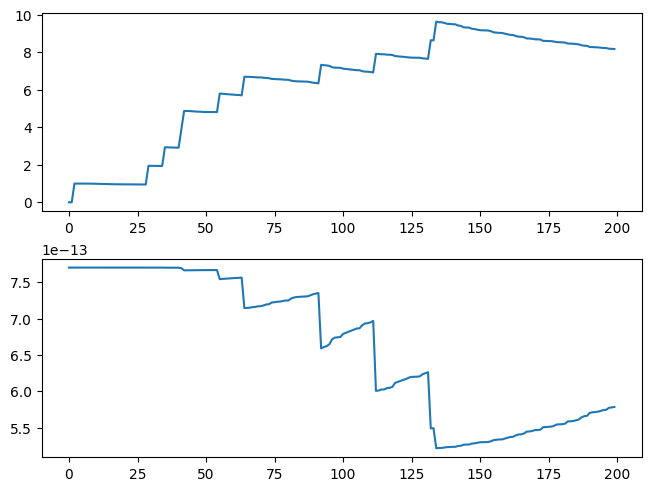

In [74]:
I_tildes    = []
I_tilde     = 0.0
tau_0       = 1e-8
slope       = 0.8
shift       = 7.5

for t in t_vals:

    I_tilde = I_tilde*np.exp(-t/tau_0)
    if np.random.rand() < 0.05:
        I_tilde += 1
    I_tildes.append(I_tilde)

I_tildes    = np.array(I_tildes)
resistances = update_bimodal_resistance(I_tildes, slope=slope, shift=shift)

fig = plt.figure(layout='constrained')
ax  = fig.add_subplot(2,1,1)
ax.plot(I_tildes)

ax  = fig.add_subplot(2,1,2)
ax.plot(resistances)

In [ ]:
plt.plot(autocorrelation(I1.iloc[:50,0].values,I1.iloc[:50,0].values,49))

In [ ]:
df_I1 = I1.iloc[:50,:]
df_I2 = I2.iloc[:50,:]

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    ax.plot(np.arange(50), df_I1.mean(axis=1), 's-', ms=2)
    ax.fill_between(np.arange(50), df_I1.mean(axis=1)-df_I1.std(axis=1)/np.sqrt(300),
                    df_I1.mean(axis=1)+df_I1.std(axis=1)/np.sqrt(300), alpha=0.5)

    ax.plot(np.arange(50), df_I2.mean(axis=1), 'o-', ms=2)
    ax.fill_between(np.arange(50), df_I2.mean(axis=1)-df_I2.std(axis=1)/np.sqrt(300),
                    df_I2.mean(axis=1)+df_I2.std(axis=1)/np.sqrt(300), alpha=0.5)

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=300, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*1.2)
    fig.set_figheight(fig.get_figheight()*1.2)

    fig.suptitle(f'Max Steps allowed : {max_jumps}, Steps per batch : {jumps_per_batch}', fontsize='small')

    ax  = fig.add_subplot(2,1,1)
    ax.errorbar(x=df1[11], y=df2[11], xerr=df1[12], yerr=df2[12], marker='.', capsize=2, ls='', ms=1, elinewidth=1, capthick=1)
    ax.set_xlabel("$I$ by $\Gamma$")
    ax.set_ylabel("$I$ by counting")
    ax.set_xlim(-1500,1500)
    ax.set_ylim(-1500,1500)

    ax  = fig.add_subplot(2,1,2)
    ax  = sns.kdeplot(df1[10], label="$I$ by $\Gamma$")
    ax  = sns.kdeplot(df2[10], label="$I$ by counting")
    ax.set_xlim(0,100000)
    ax.set_xlabel('KMC Steps')
    ax.set_ylabel('')
    ax.legend()

    fig.savefig(f"count_vs_gamma_{jumps_per_batch}.png")

In [ ]:
voltages        = np.zeros(shape=(300,3))
voltages[:,0]   = np.linspace(0,0.1,300)

topology_parameter = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[6,6,0]]
}

In [ ]:
jumps_per_batch = 1000
max_jumps       = 100000

sim_dic1 ={
    'error_th'        : 0.05,
    'max_jumps'       : max_jumps,
    'eq_steps'        : 1000,
    'jumps_per_batch' : jumps_per_batch,
    'kmc_counting'    : False
}

sim_dic2 ={
    'error_th'        : 0.05,
    'max_jumps'       : max_jumps,
    'eq_steps'        : 1000,
    'jumps_per_batch' : jumps_per_batch,
    'kmc_counting'    : True
}

In [ ]:
t1 = time.process_time()
df1, I1 = run_kmc(voltages, topology_parameter, sim_dic1)
t2 = time.process_time()
print(t2-t1)

df2, I2 = run_kmc(voltages, topology_parameter, sim_dic2)
t3 = time.process_time()
print(t3-t2)

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    ax.errorbar(df1[0]*1000, df1[5], np.abs(df1[6]), marker='o', label=f'Gamma-KMC',
                ms=2, capsize=2, markevery=10, errorevery=10, lw=0.5)
    ax.errorbar(df2[0]*1000, df2[5], np.abs(df2[6]), marker='s', label=f'Counting-KMC',
                ms=2, capsize=2, markevery=(5,10), errorevery=(5,10), lw=0.5)

    ax.set_xlabel('$U$ [mV]')
    ax.set_ylabel('$I$ [pA]')
    ax.legend(fontsize='small')

In [ ]:
dic             = {}
net_parameter   = [[2,1],[2,2],[3,2],[3,3]]
jumps_per_stat  = 50000

for i,net_params in enumerate(net_parameter):

    # Network Parameter
    topology_parameter = {
        "Nx"    : net_params[0],
        "Ny"    : net_params[1],
        "Nz"    : 1,
        "e_pos" : [[0,0,0],[net_params[0]-1,net_params[1]-1,0]]
    }

    sim_dic ={
        'error_th'        : 0.05,
        'max_jumps'       : 1000000,
        'eq_steps'        : 10000,
        'jumps_per_stat'  : jumps_per_stat}

    voltages        = np.zeros(shape=(600,3))
    voltages[:,0]   = np.linspace(0,0.1,600)

    np_network_cubic = nanonets.simulation(network_topology='cubic', topology_parameter=topology_parameter)
    np_network_cubic.run_const_voltages(voltages=voltages, target_electrode=1, save_th=0.1, output_potential=False, sim_dic=sim_dic)

    df1      = pd.DataFrame(np.hstack((voltages,np_network_cubic.return_output_values())))
    df1[7]   = np_network_cubic.return_potential_landscape()[:,topology_parameter['Nx']*topology_parameter['Ny']+1]
    df1      = df1.sort_values(by=0)
    dic[i]   = df1

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    for key, df in dic.items():

        ax.plot(df[7]*1000, df[5], '.', label=f'$N_x = {net_parameter[key][0]}$, $N_y = {net_parameter[key][1]}$', ms=2)

    ax.set_xlabel('NP Potential')
    ax.set_ylabel('Current')
    ax.set_ylim(0,5000)
    ax.set_xlim(0,30)
    ax.legend(fontsize='small')

    fig.savefig(f'I_phi_{jumps_per_stat}.png')

In [ ]:
ele_charge  = 0.160217662
c_inv       = np_network_cubic.inv_capacitance_matrix

def free_energy1(pot):
    return -ele_charge*pot + (ele_charge*ele_charge/2)*c_inv[3,3]

def free_energy2(pot):
    return ele_charge*pot + (ele_charge*ele_charge/2)*c_inv[3,3]

def tunnel_rate(df):

    R           = 25e-12
    gamma       = np.zeros(len(df))
    gamma[df<0] = -df[df<0]/(ele_charge*ele_charge*R)

    return gamma

In [ ]:
# def pot_current_dep(voltages, n_jumps=10000, eq_steps=10000):

#     pot_landscape   = np.zeros(n_jumps)
#     time_vals       = np.zeros(n_jumps)
#     pos_jumps       = np.zeros(n_jumps)
#     neg_jumps       = np.zeros(n_jumps)
#     rate_diffs      = np.zeros(n_jumps)

#     np_network_cubic    = nanonets.simulation(network_topology='cubic', topology_parameter=topology_parameter)

#     # Based on current voltages get charges and potentials
#     np_network_cubic.init_charge_vector(voltages)
#     np_network_cubic.init_potential_vector(voltages)
#     np_network_cubic.init_const_capacitance_values()
#     np_network_cubic.np_target_electrode_electrostatic_properties(1)

#     # Return Model Arguments
#     inv_capacitance_matrix                                                                  = np_network_cubic.return_inv_capacitance_matrix()
#     charge_vector                                                                           = np_network_cubic.return_charge_vector()
#     potential_vector                                                                        = np_network_cubic.return_potential_vector()
#     const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2    = np_network_cubic.return_const_capacitance_values()
#     N_electrodes, N_particles                                                               = np_network_cubic.return_particle_electrode_count()
#     adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2, co_adv_index3             = np_network_cubic.return_advanced_indices()
#     temperatures, temperatures_co                                                           = np_network_cubic.return_const_temperatures(T=0.0)
#     resistances, resistances_co1, resistances_co2                                           = np_network_cubic.return_random_resistances(R=np_network_cubic.res_info['mean_R'], Rstd=np_network_cubic.res_info['std_R'])
#     idx_np_target, C_np_self, C_np_target                                                   = np_network_cubic.return_output_electrostatics()

#     # Pass all model arguments into Numba optimized Class
#     model = nanonets.model_class(charge_vector, potential_vector, inv_capacitance_matrix, const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2,
#                             temperatures, temperatures_co, resistances, resistances_co1, resistances_co2, adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2,
#                             co_adv_index3, N_electrodes, N_particles, C_np_target, C_np_self)
    
#     model.calc_potentials()

#     for i in range(eq_steps):
        
#         random_number1  = np.random.rand()
#         random_number2  = np.random.rand()
#         model.calc_tunnel_rates_zero_T()
#         model.select_event(random_number1, random_number2)

#     model.time = 0.0

#     rate_index1 = np.where(np_network_cubic.adv_index_cols == 1)[0][0]
#     rate_index2 = np.where(np_network_cubic.adv_index_rows == 1)[0][0]

#     for i in range(n_jumps):

#         t1 = model.time
        
#         pot_landscape[i]= model.potential_vector[5]
        
#         random_number1  = np.random.rand()
#         random_number2  = np.random.rand()
#         model.calc_tunnel_rates_zero_T()
#         rate_diffs[i] = model.tunnel_rates[rate_index1] - model.tunnel_rates[rate_index2]
#         model.select_event(random_number1, random_number2)

#         np1 = model.adv_index_rows[model.jump]
#         np2 = model.adv_index_cols[model.jump]

#         # If jump from target electrode
#         if (np1 == 1):
#             neg_jumps[i] = 1
            
#         # If jump towards target electrode
#         if (np2 == 1):
#             pos_jumps[i] = 1
        
#         t2 = model.time

#         time_vals[i] = t2-t1
    
#     return pd.DataFrame((np.array(pot_landscape),np.sum(np.array(time_vals)),pos_jumps-neg_jumps, np.array(rate_diffs))).T

In [ ]:
def pot_current_dep(voltages, topology_parameter, n_jumps=10000, eq_steps=10000):

    pot_landscape   = np.zeros(n_jumps)
    time_vals       = np.zeros(n_jumps)
    pos_jumps       = np.zeros(n_jumps)
    neg_jumps       = np.zeros(n_jumps)
    rate_diffs      = np.zeros(n_jumps)

    np_network_cubic    = nanonets.simulation(network_topology='cubic', topology_parameter=topology_parameter)

    # Based on current voltages get charges and potentials
    np_network_cubic.init_charge_vector(voltages)
    np_network_cubic.init_potential_vector(voltages)
    np_network_cubic.init_const_capacitance_values()
    np_network_cubic.np_target_electrode_electrostatic_properties(1)

    # Return Model Arguments
    inv_capacitance_matrix                                                                  = np_network_cubic.return_inv_capacitance_matrix()
    charge_vector                                                                           = np_network_cubic.return_charge_vector()
    potential_vector                                                                        = np_network_cubic.return_potential_vector()
    const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2    = np_network_cubic.return_const_capacitance_values()
    N_electrodes, N_particles                                                               = np_network_cubic.return_particle_electrode_count()
    adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2, co_adv_index3             = np_network_cubic.return_advanced_indices()
    temperatures, temperatures_co                                                           = np_network_cubic.return_const_temperatures(T=0.0)
    resistances, resistances_co1, resistances_co2                                           = np_network_cubic.return_random_resistances(R=np_network_cubic.res_info['mean_R'], Rstd=np_network_cubic.res_info['std_R'])
    idx_np_target, C_np_self, C_np_target                                                   = np_network_cubic.return_output_electrostatics()

    # Pass all model arguments into Numba optimized Class
    model = nanonets.model_class(charge_vector, potential_vector, inv_capacitance_matrix, const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2,
                            temperatures, temperatures_co, resistances, resistances_co1, resistances_co2, adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2,
                            co_adv_index3, N_electrodes, N_particles, C_np_target, C_np_self)
    
    model.calc_potentials()

    for i in range(eq_steps):
        
        random_number1  = np.random.rand()
        random_number2  = np.random.rand()
        model.calc_tunnel_rates_zero_T()
        model.select_event(random_number1, random_number2)

    model.time = 0.0

    rate_index1 = np.where(np_network_cubic.adv_index_cols == 1)[0][0]
    rate_index2 = np.where(np_network_cubic.adv_index_rows == 1)[0][0]

    for i in range(n_jumps):

        t1 = model.time
        
        pot_landscape[i]= model.potential_vector[topology_parameter['Nx']*topology_parameter['Ny']+1]
        
        random_number1  = np.random.rand()
        random_number2  = np.random.rand()
        model.calc_tunnel_rates_zero_T()
        rate_diffs[i] = model.tunnel_rates[rate_index1] - model.tunnel_rates[rate_index2]
        model.select_event(random_number1, random_number2)

        np1 = model.adv_index_rows[model.jump]
        np2 = model.adv_index_cols[model.jump]

        # If jump from target electrode
        if (np1 == 1):
            neg_jumps[i] = 1
            
        # If jump towards target electrode
        if (np2 == 1):
            pos_jumps[i] = 1
        
        t2 = model.time

        time_vals[i] = t2-t1
    
    return [np.mean(np.array(pot_landscape)),np.sum(np.array(time_vals)),np.sum(pos_jumps-neg_jumps), np.sum(np.array(rate_diffs)*time_vals)*(10**(-6))/np.sum(time_vals)]

In [ ]:
dic1            = {}
dic2            = {}
net_parameter   = [[2,1],[2,2],[3,2],[3,3]]
jumps_per_stat  = 1000

for i,net_params in enumerate(net_parameter):

    # Network Parameter
    topology_parameter = {
        "Nx"    : net_params[0],
        "Ny"    : net_params[1],
        "Nz"    : 1,
        "e_pos" : [[0,0,0],[net_params[0]-1,net_params[1]-1,0]]
    }

    sim_dic ={
        'error_th'        : 0.05,
        'max_jumps'       : 1000000,
        'eq_steps'        : 10000,
        'jumps_per_stat'  : jumps_per_stat}

    voltages        = np.zeros(shape=(600,3))
    voltages[:,0]   = np.linspace(0,0.1,600)

    np_network_cubic = nanonets.simulation(network_topology='cubic', topology_parameter=topology_parameter)
    np_network_cubic.run_const_voltages(voltages=voltages, target_electrode=1, save_th=0.1, output_potential=False, sim_dic=sim_dic)

    df1      = pd.DataFrame(np.hstack((voltages,np_network_cubic.return_output_values())))
    df1[7]   = np_network_cubic.return_potential_landscape()[:,topology_parameter['Nx']*topology_parameter['Ny']+1]
    df1      = df1.sort_values(by=0)
    dic1[i]  = df1

    ##########################################################

    vals = []

    for V in voltages[:,0]:

        v_array = np.array([V,0.0,0.0])
        vals.append(pot_current_dep(v_array, topology_parameter, jumps_per_stat))

    df1 = pd.DataFrame(vals)
    dic2[i] = df1

In [ ]:
dic1[i]*ele_charge

In [ ]:
with plt.style.context(["science","bright","grid"]):
    
    fig = plt.figure(dpi=200)
    fig.set_figwidth(fig.get_figwidth()*1.5)

    for i in dic.keys():

        ax  = fig.add_subplot(2,2,i+1)
        ax.plot(np.linspace(0,0.1,600)*1000, dic2[i][3].values*ele_charge, 'o', label='$I = e \cdot (\Gamma_+ - \Gamma_-)$', ms=1)
        ax.plot(np.linspace(0,0.1,600)*1000, dic1[i][5]*ele_charge, 'o', label='$I$ based on counting', ms=1)
        
        if i == 0:
            ax.legend(loc='center', bbox_to_anchor=(1,1.2), ncol=2)
        if i == 0 or i == 2:
            ax.set_ylabel('I [pA]')
        if i == 2 or i == 3:
            ax.set_xlabel('U [mV]')
        
        ax.set_ylim(0,800)
        ax.set_xlim(0,100)

    fig.savefig("I_comparsion.png")

In [ ]:
n_jumps     = 10000
vals        = []

for V in np.linspace(-0.1,0.1,600):

    voltages    = np.array([V,0.0,0.0])
    vals.append(pot_current_dep(voltages, topology_parameter, jumps_per_stat))
    
df = pd.DataFrame(vals)
df

In [ ]:
plt.plot(np.cumsum(df[1]), df[3]*10**(-6))

In [ ]:
free_e = free_energy(df[0])

with plt.style.context(["science","bright"]):
    
    plt.figure(dpi=200)
    plt.plot(df[0], '.-')
    plt.plot(free_e)
    plt.vlines(np.arange(len(df[1]))[df[2].values == 1], ymin=0, ymax=0.15, color='black', lw=0.5)
    plt.xlim(0,100)
    plt.ylim(0, 0.1)
    plt.ylabel('Potential')
    plt.xlabel('Jumps')

In [ ]:
gamma = tunnel_rate(free_e)

with plt.style.context(["science","bright"]):
    plt.figure(dpi=200)
    plt.plot(gamma)
    plt.vlines(np.arange(len(df[1]))[df[2].values == 1], ymin=0, ymax=0.15, color='black', lw=0.5)
    plt.xlim(0,100)
    plt.ylabel('Gamma')
    plt.xlabel('Jumps')

In [ ]:
with plt.style.context(["science","bright"]):
    plt.figure(dpi=200)
    plt.plot(np.cumsum(df[1]),df[0], '.-')
    plt.vlines(np.cumsum(df[1]).values[df[2].values == 1], ymin=0, ymax=0.15, color='black', lw=0.5)
    plt.ylim(0, 0.1)
    plt.xlim(0,2e-9)
    plt.ylabel('Potential')
    plt.xlabel('Time')

In [ ]:
I = tunnel_rate(free_energy1(df[0])) - tunnel_rate(free_energy2(df[0]))
plt.plot(I)
plt.xlim(0,100)

In [ ]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200,layout='constrained')
    ax  = fig.add_subplot()
    ax.plot(np.cumsum(df[1]), np.cumsum(df[2]), '.-')
    ax.set_xlim(0,1e-9)
    ax.set_ylim(0,10)

    ax2 = ax.twinx()
    ax2.plot(np.cumsum(df[1]), df[0], '.-', c='red')
    ax2.set_xlim(0,1e-9)

In [ ]:
vals_per_bin    = 2
df[3]           = np.repeat(np.arange(1,n_jumps/vals_per_bin+1),vals_per_bin)
df_bins         = df[[0,3]].groupby(by=3).mean()
df_bins[1]      = df[[2,3]].groupby(by=3).sum()[2]/df[[1,3]].groupby(by=3).sum()[1]

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200,layout='constrained')
    ax  = fig.add_subplot(3,1,1)
    ax.plot(df_bins[0], df_bins[1], '.')

    ax  = fig.add_subplot(3,1,2)
    ax.plot(df_bins[0], '.')

    ax  = fig.add_subplot(3,1,3)
    ax.plot(df_bins[1], '.')